### Data Setup for Models

In [48]:
# Connect to SQLite database
import sqlite3
from pathlib import Path

__file__ = %pwd
DATA = Path(__file__).parent / "data"
PRIORITIES = DATA / "Priorities"
DATABASE = DATA / "databases" / "exploration.db"
con = sqlite3.connect(DATABASE)
cur = con.cursor()

In [49]:
# Load Data
import pandas as pd
import numpy as np

df = pd.read_sql_query("SELECT * FROM ACGR", con)

# Count missing values for each column
df.replace('*', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')

### Data Summary

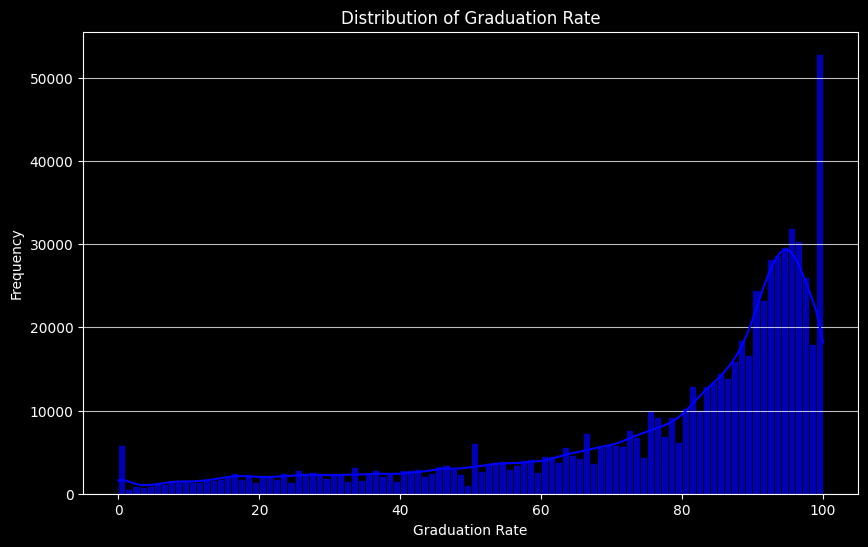

Mean Graduation Rate: 76.66736629192883


In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['RegHSDiplomaRate'].dropna(), bins=100, kde=True, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Graduation Rate")
plt.ylabel("Frequency")
plt.title("Distribution of Graduation Rate")
plt.grid(axis='y', alpha=0.75)
plt.show()


mean_graduation_rate = df['RegHSDiplomaRate'].mean()
print(f"Mean Graduation Rate: {mean_graduation_rate}")  

### Lasso Regression with RegHSDiplomaRate as target

Number of features after encoding: 28

DropoutRate: -15.273317053746984
StillEnrolledRate: -10.619980182317272
SPEDRate: -4.402505661100122
OtherRate: -3.1106272322132504
AdultEdRate: -1.3251049936696122
GEDRate: -0.8566682199089909
CPPRate: -0.8489519914972996
AdultEd: -0.0
Biliteracy: 0.0
BiliteracyRate: 0.0
CPP: -0.0
CohortStudents: 0.0
CountyCode: -0.0
DistrictCode: 0.0
Dropout: -0.0
Exemption: -0.0
ExemptionRate: -0.0
GED: -0.0
Merit: 0.0
MeritRate: 0.0
Other: -0.0
RegHSDiploma: 0.0
SPED: -0.0
SchoolCode: 0.0
StillEnrolled: -0.0
UniReqs: 0.0
UniReqsPercent: 0.0
cdsCode: -0.0


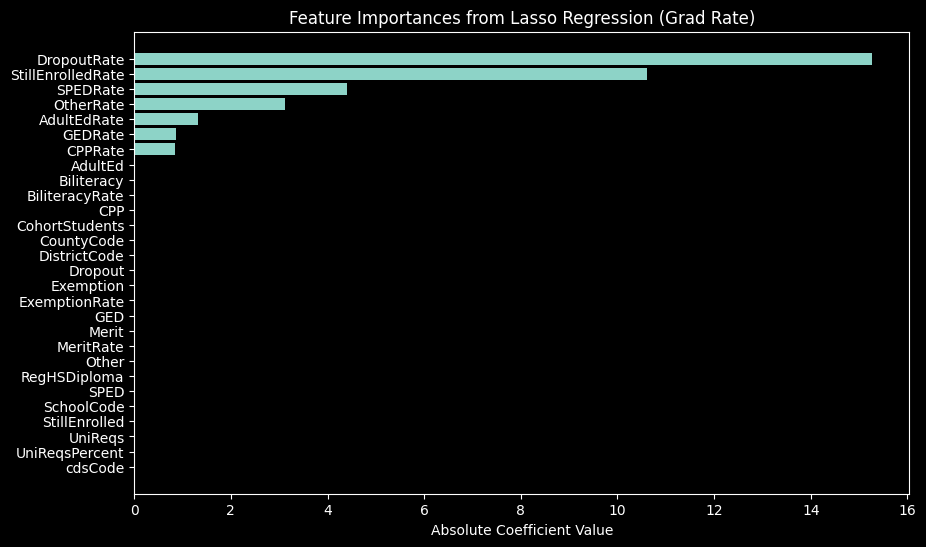

In [62]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Convert categorical variables to dummy variables
categorical_cols = ['AggregateLevel', 'CharterSchool', 'DASS', 'ReportingCategory', 'Year']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Define the target variable
target_column = 'RegHSDiplomaRate'

# Convert the target column to numeric, coercing errors to NaN
df[target_column] = pd.to_numeric(df[target_column], errors='coerce')


# Define numeric features
numeric_features = df.columns.difference(categorical_cols).tolist()

# Drop rows with NaN values in the target column or features
df_encoded.dropna(subset=numeric_features + [target_column, "DropoutRate"], inplace=True)

# Drop rows with NaN values in the categorical columns after encoding
df_encoded.dropna(inplace=True)

numeric_features = df_encoded.columns.difference(categorical_cols + [target_column]).tolist()

X = df_encoded[numeric_features]
y = df_encoded[target_column]


print(f"Number of features after encoding: {X.shape[1]}")


# Create a pipeline with scaling and Lasso with cross-validation
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42))
])

# Fit the model
pipe.fit(X, y)

# Get the coefficients of the Lasso model
lasso_coefficients = pipe['lasso'].coef_
# Print features and coefficients sorted by absolute value of coefficient (highest first)
coef_feature_pairs = list(zip(X.columns, lasso_coefficients))
sorted_pairs = sorted(coef_feature_pairs, key=lambda x: abs(x[1]), reverse=True)
print()
for feature, coef in sorted_pairs:
    print(f"{feature}: {coef}")

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh([f[0] for f in sorted_pairs], [abs(f[1]) for f in sorted_pairs])
plt.xlabel("Absolute Coefficient Value")
plt.title("Feature Importances from Lasso Regression (Grad Rate)")
plt.gca().invert_yaxis()
plt.show()


### Lasso Model Validation

In [52]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipe.fit(X_train, y_train)

# Make predictions
y_pred = pipe.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_2 = pipe.score(X_test, y_test)
print(f"R^2 Score: {r_2}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Best alpha value: {pipe['lasso'].alpha_}")

R^2 Score: 0.9999896218197629
Mean Squared Error: 0.004552091063553144
Root Mean Squared Error: 0.06746918603001777
Best alpha value: 0.017336346776963555


### Lasso Residuals and Actual vs. Predicted

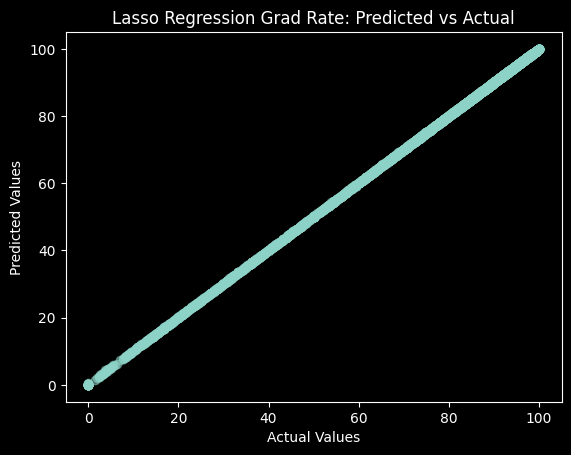

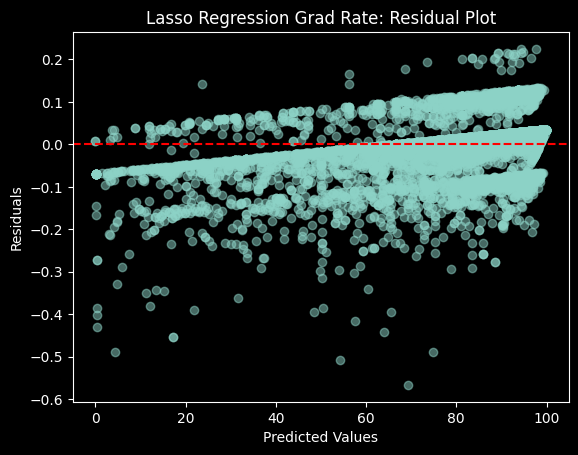

In [53]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Lasso Regression Grad Rate: Predicted vs Actual")
plt.show()

# Convert y_test to numeric
y_test_numeric = pd.to_numeric(y_test, errors='coerce')

# Calculate residuals
residuals = y_test_numeric - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Lasso Regression Grad Rate: Residual Plot")
plt.show()

### XGBoost Model for Graduation Rate

Feature ranking:
1. DropoutRate (0.4326463043689728)
2. StillEnrolledRate (0.2025723159313202)
3. RegHSDiploma (0.08545004576444626)
4. StillEnrolled (0.07989539951086044)
5. Merit (0.035831667482852936)
6. Dropout (0.030536886304616928)
7. SPEDRate (0.02850891277194023)
8. OtherRate (0.020630694925785065)
9. UniReqsPercent (0.019811663776636124)
10. UniReqs (0.01828678883612156)
11. Biliteracy (0.008930190466344357)
12. AdultEdRate (0.005604129284620285)
13. CohortStudents (0.004945402964949608)
14. SPED (0.004889630246907473)
15. GED (0.003912773448973894)
16. Other (0.0035280869342386723)
17. DistrictCode (0.0031276505906134844)
18. CPPRate (0.0030271646101027727)
19. GEDRate (0.0023752020206302404)
20. AdultEd (0.002363011008128524)
21. CPP (0.00154927559196949)
22. Exemption (0.00032182809081859887)
23. MeritRate (0.00031501930789090693)
24. ExemptionRate (0.00021274967002682388)
25. CountyCode (0.00021104955521877855)
26. cdsCode (0.00018766659195534885)
27. SchoolCode (0.0001786

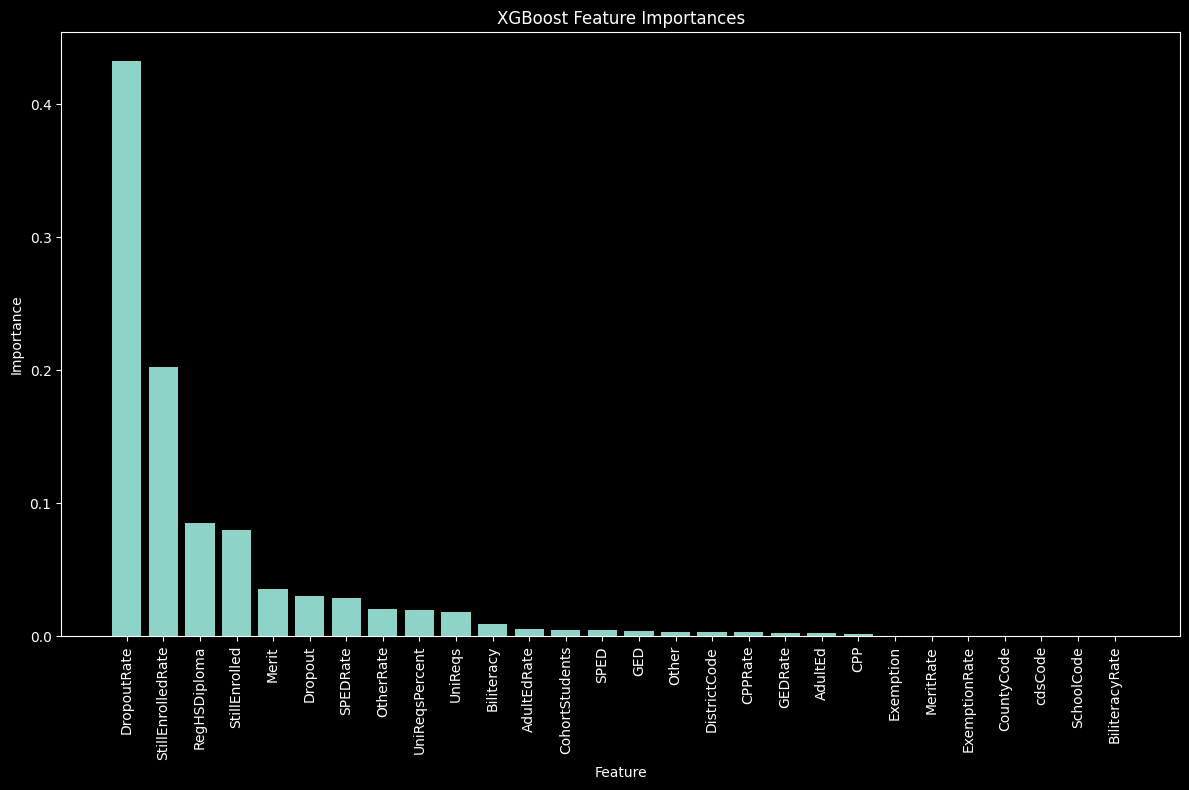

In [54]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split


# Proceed with XGBoost training
xgb_regressor = xgb.XGBRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6,  
    subsample=0.8,  
    colsample_bytree=0.8, 
    missing=np.nan, 
    random_state=42
)


# Fit the model
xgb_regressor.fit(X, y)

# Get feature importances
importances = xgb_regressor.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]})")

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()

### XGBoost Model Validation

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_regressor.fit(X_train, y_train)
y_pred = xgb_regressor.predict(X_test)


# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_2 = xgb_regressor.score(X_test, y_test)

print(f"XGBoost R^2 Score: {r_2}")
print(f"XGBoost Mean Squared Error: {mse}")
print(f"XGBoost Root Mean Squared Error: {rmse}")
print(f"XGBoost Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")

XGBoost R^2 Score: 0.9980248576007376
XGBoost Mean Squared Error: 0.8663395566044884
XGBoost Root Mean Squared Error: 0.9307736333848786
XGBoost Mean Absolute Error: 0.5291689162175225


### XGBoost Residuals & Actual vs. Predicted

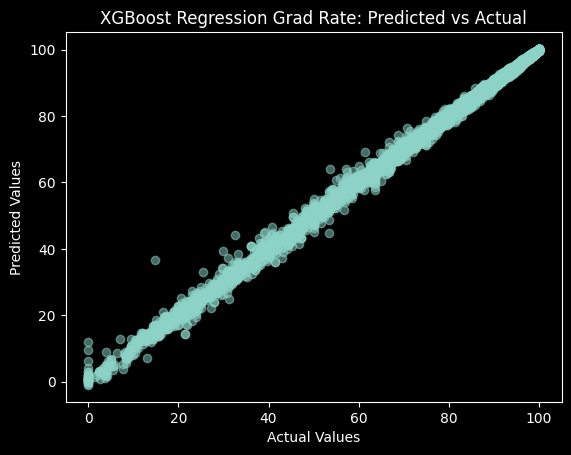

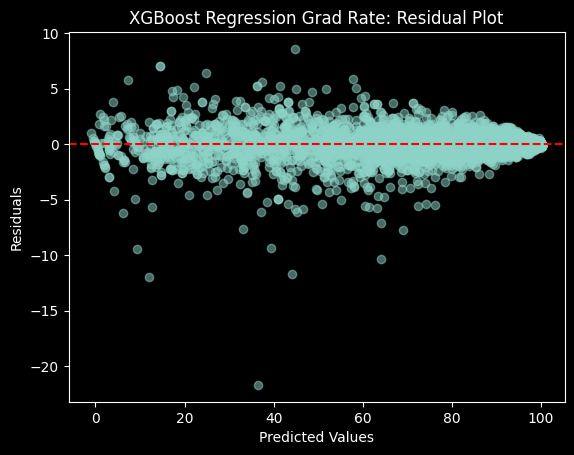

In [56]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("XGBoost Regression Grad Rate: Predicted vs Actual")
plt.show()

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("XGBoost Regression Grad Rate: Residual Plot")
plt.show()

### Lasso Model for CSU/UC Rate




MeritRate: 13.096894628073647
BiliteracyRate: 6.679554621866397
RegHSDiplomaRate: 4.351287233172787
ExemptionRate: -2.2118360854337853
OtherRate: -1.8280801701089797
DropoutRate: -1.5626923590981425
cdsCode: -0.7545840703908409
DistrictCode: -0.7478666851187189
SchoolCode: -0.5331867688801026
Dropout: 0.30471946817842366
StillEnrolled: 0.2769483178704063
Exemption: -0.25636655568689376
CohortStudents: 0.14977272639983583
SPEDRate: -0.13423623043254396
GEDRate: -0.1310690114942127
CPPRate: 0.036839853016656654
AdultEd: 0.0
AdultEdRate: -0.0
Biliteracy: 0.0
CPP: 0.0
CountyCode: -0.0
GED: 0.0
Merit: -0.0
Other: 0.0
RegHSDiploma: 0.0
SPED: -0.0
StillEnrolledRate: 0.0


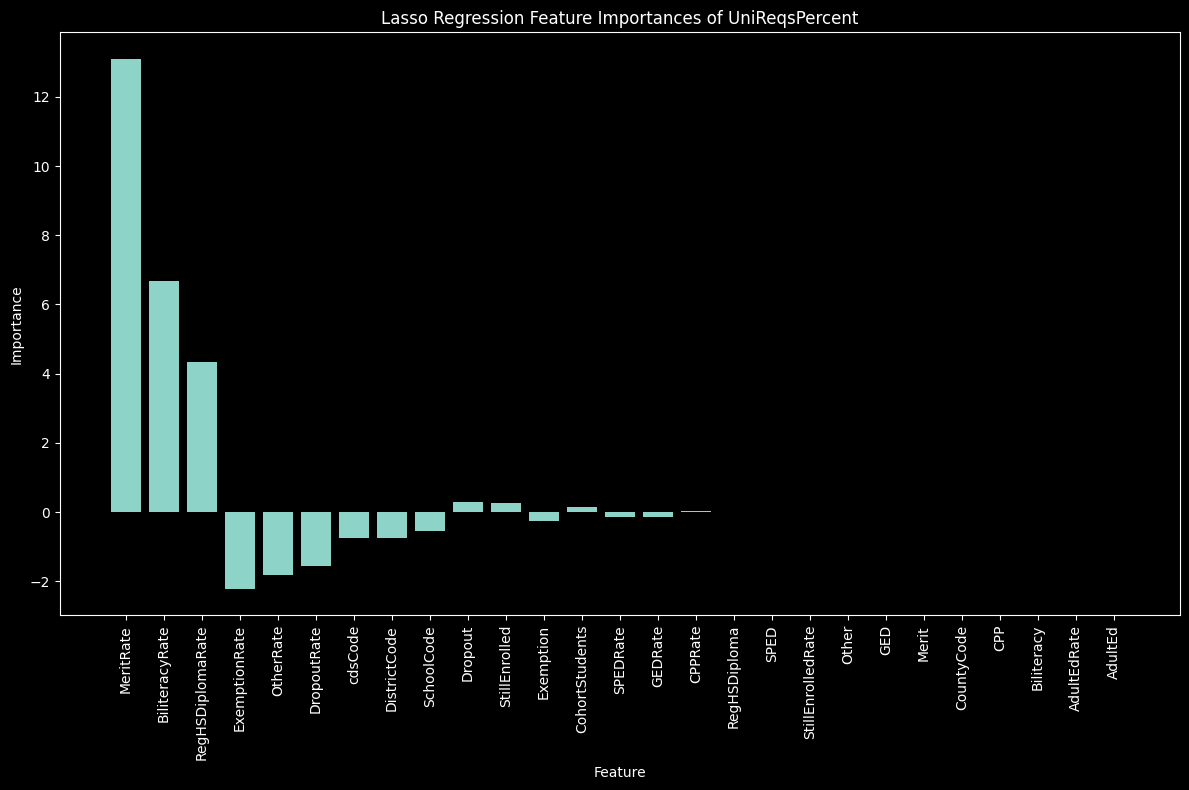

In [57]:
# Lasso Regression for UniReqsPercent as target variable

df = pd.read_sql_query("SELECT * FROM ACGR", con)
df.replace('*', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')

# Convert categorical variables to dummy variables
categorical_cols = ['AggregateLevel', 'CharterSchool', 'DASS', 'ReportingCategory', 'Year']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Define the target variable
target_column = 'UniReqsPercent'

# Convert the target column to numeric, coercing errors to NaN
df[target_column] = pd.to_numeric(df[target_column], errors='coerce')


# Define numeric features
numeric_features = df.columns.difference(categorical_cols).tolist()

# Drop rows with NaN values in the target column or features
df_encoded.dropna(subset=numeric_features + [target_column], inplace=True)

# Drop rows with NaN values in the categorical columns after encoding
df_encoded.dropna(inplace=True)

numeric_features = df_encoded.columns.difference(categorical_cols + [target_column, "UniReqs"]).tolist()

X = df_encoded[numeric_features]
y = df_encoded[target_column]

pipe_uni = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42))
])

pipe_uni.fit(X, y)

# Get the coefficients of the Lasso model
lasso_coefficients_uni = pipe_uni['lasso'].coef_

# Print features and coefficients sorted by absolute value of coefficient (highest first)
coef_feature_pairs_uni = list(zip(X.columns, lasso_coefficients_uni))
sorted_pairs_uni = sorted(coef_feature_pairs_uni, key=lambda x: abs(x[1]), reverse=True)
print()

for feature, coef in sorted_pairs_uni:
    print(f"{feature}: {coef}")

# Plot feature importances for UniReqsPercent Lasso
sorted_idx_uni = np.argsort(np.abs(lasso_coefficients_uni))[::-1]
plt.figure(figsize=(12, 8))
plt.bar(range(len(lasso_coefficients_uni)), lasso_coefficients_uni[sorted_idx_uni], align='center')
plt.xticks(range(len(lasso_coefficients_uni)), X.columns[sorted_idx_uni], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Lasso Regression Feature Importances of UniReqsPercent")
plt.tight_layout()
plt.show()

### Lasso CSU/UC Percent Model Validation

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe_uni.fit(X_train, y_train)

y_pred = pipe_uni.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_2 = pipe_uni.score(X_test, y_test)
print(f"R^2 Score: {r_2}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Best alpha value: {pipe['lasso'].alpha_}")

R^2 Score: 0.5734474097396287
Mean Squared Error: 366.85338064325265
Root Mean Squared Error: 19.15341694432752
Best alpha value: 0.017336346776963555


### Residuals and Predicted vs. Actual

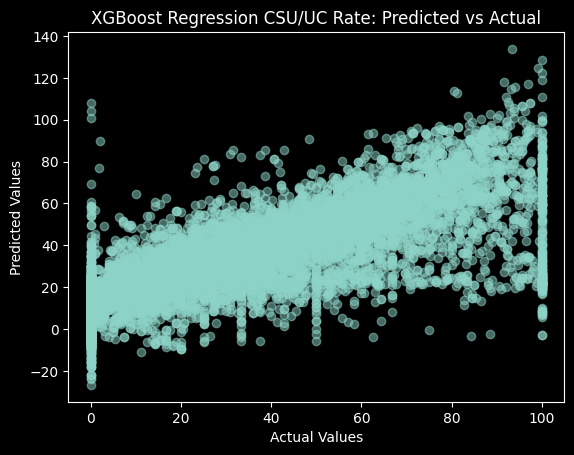

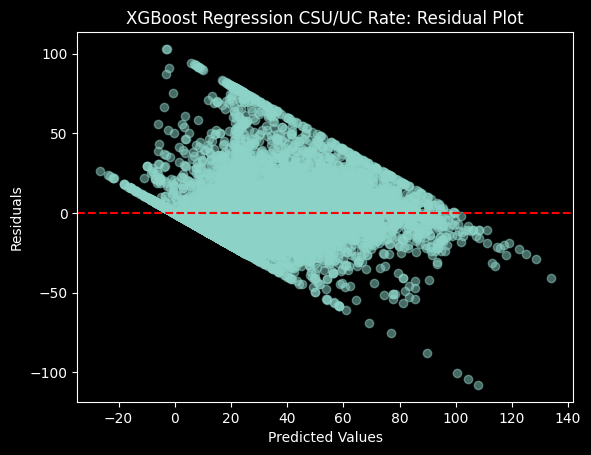

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Lasso Regression CSU/UC Rate: Predicted vs Actual")
plt.show()

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Lasso Regression CSU/UC Rate: Residual Plot")
plt.show()

### XGBoost for CSU/UC Rate

Feature ranking:
1. RegHSDiplomaRate (0.33150967955589294)
2. MeritRate (0.25617268681526184)
3. BiliteracyRate (0.08363858610391617)
4. Merit (0.05582340434193611)
5. CountyCode (0.028438573703169823)
6. cdsCode (0.02726810798048973)
7. DistrictCode (0.02308424934744835)
8. SchoolCode (0.021049432456493378)
9. DropoutRate (0.01981739141047001)
10. RegHSDiploma (0.017885006964206696)
11. OtherRate (0.01350289024412632)
12. GEDRate (0.012230624444782734)
13. AdultEdRate (0.011849850416183472)
14. StillEnrolled (0.011401699855923653)
15. CohortStudents (0.011322238482534885)
16. AdultEd (0.009229257702827454)
17. StillEnrolledRate (0.009142788127064705)
18. GED (0.008755553513765335)
19. Other (0.008600935339927673)
20. Biliteracy (0.00777889508754015)
21. Exemption (0.006779057905077934)
22. Dropout (0.00640529440715909)
23. ExemptionRate (0.005463588051497936)
24. SPEDRate (0.005271808709949255)
25. SPED (0.0030880013946443796)
26. CPPRate (0.002825668780133128)
27. CPP (0.001664703129

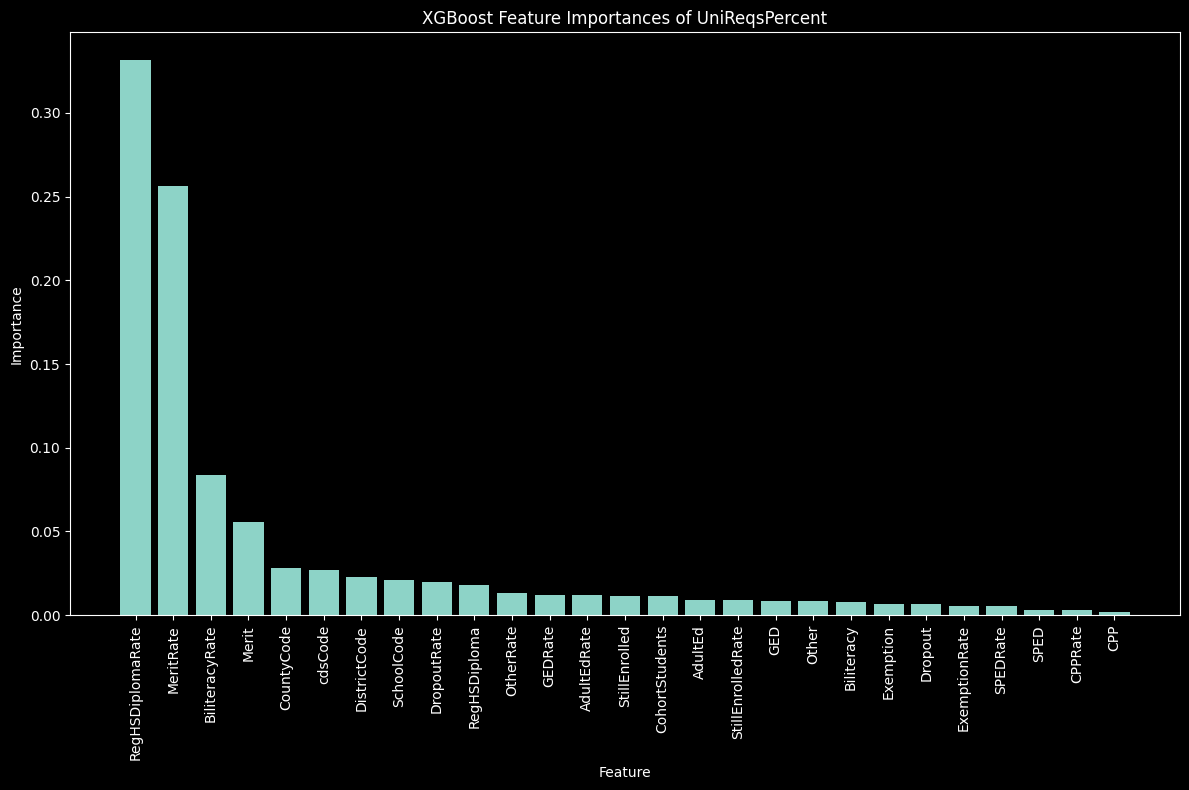

In [68]:
df_uni = pd.read_sql_query("SELECT * FROM ACGR", con)

# Count missing values for each column
df_uni.replace('*', np.nan, inplace=True)

df_uni = df_uni.apply(pd.to_numeric, errors='coerce')

target_col = 'UniReqsPercent'

df[target_col] = pd.to_numeric(df[target_col], errors='coerce')

categorical_cols = ['AggregateLevel', 'CharterSchool', 'DASS', 'ReportingCategory', 'Year']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_encoded.dropna(subset=[target_col], inplace=True)

X = df_encoded.drop(columns=[target_col, "UniReqs"])
y = df_encoded[target_col]

# XGBoost for UniReqsPercent as target variable
xgb_regressor_uni = xgb.XGBRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6,  
    subsample=0.8,  
    colsample_bytree=0.8, 
    missing=np.nan, 
    random_state=42
)

# Fit the model
xgb_regressor_uni.fit(X, y)

# Get feature importances
importances_uni = xgb_regressor_uni.feature_importances_
feature_names_uni = X.columns
indices_uni = np.argsort(importances_uni)[::-1]
print("Feature ranking:")
for f in range(len(feature_names_uni)):
    print(f"{f + 1}. {feature_names_uni[indices_uni[f]]} ({importances_uni[indices_uni[f]]})")

# Plot feature importances for UniReqsPercent
plt.figure(figsize=(12, 8))
plt.bar(range(len(feature_names_uni)), importances_uni[indices_uni], align='center')
plt.xticks(range(len(feature_names_uni)), feature_names_uni[indices_uni], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("XGBoost Feature Importances of UniReqsPercent")
plt.tight_layout()
plt.show()

### XGBoost CSU/UC Rate Model Validation

In [67]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
xgb_regressor_uni.fit(X_train, y_train)

# Make predictions
y_pred = xgb_regressor_uni.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 7.275840583724718
Root Mean Squared Error: 2.6973766113994384
Mean Absolute Error: 1.765212504622669
R^2 Score: 0.991797542349975


### XGBoost CSU/UC Rate Residuals vs. Actual

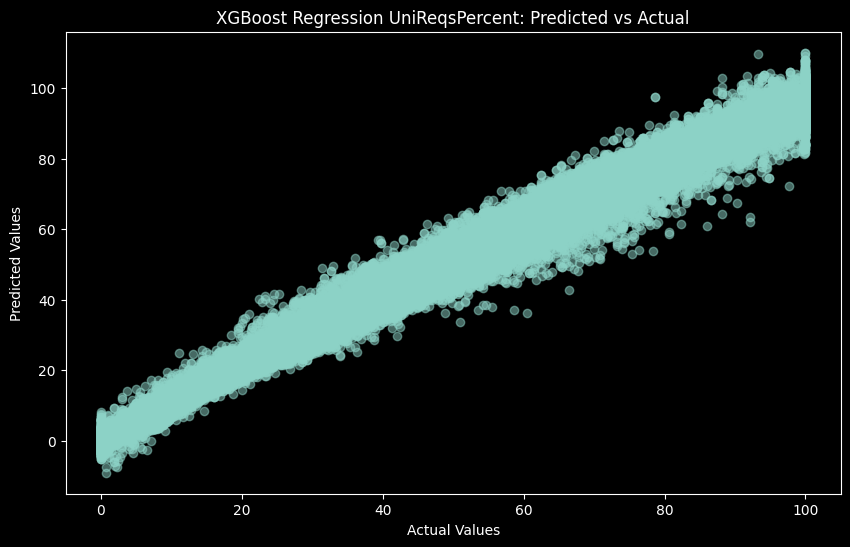

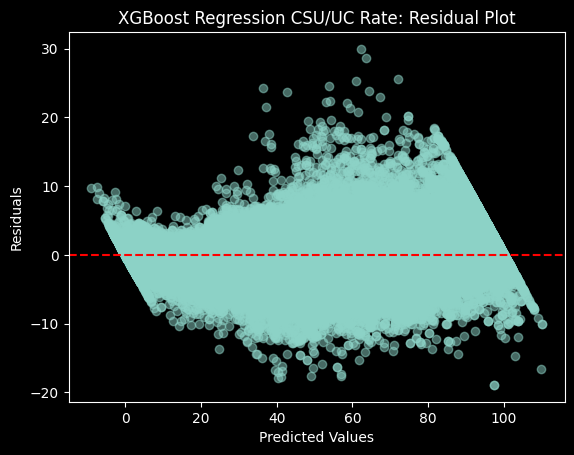

In [70]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("XGBoost Regression UniReqsPercent: Predicted vs Actual")
plt.show()

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("XGBoost Regression CSU/UC Rate: Residual Plot")
plt.show()